# Reddit network centrality
**Author: Austin Larson**

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import graspologic as gp
import scipy
from umap import UMAP

## Environment
For simplicity, I used a venv virtual environment with the following requirements.txt:

numpy <=1.21.0
graspologic
scikit-learn
scipy
seaborn
ipykernel
ipython
networkx
umap

## Dataset description
This dataset is stored in two separate files. One tsv shows all hyperlinks in title, while the other has in body of message. I only use the title file, which should have a more correlated relationship. All information on the data can be found at the following website:
https://snap.stanford.edu/data/soc-RedditHyperlinks.html

WARNING! Please note that I do not have any control over what the subreddit names are, and the data is not reduced to only contain "safe for work" content. There may be pornography, use of graphic language, racist themes, or any other terrible thing you may find on the internet. With the way I have the data displayed, any sort of indexing does not show these subreddit names. However, if this data is explored further, there may be inappropriate subreddit names that can be shown.

The weight used the number of times this direction occurred.

In [3]:
df = pd.read_csv(r'C:\Users\austi\Downloads\soc-redditHyperlinks-title.tsv', sep='\t')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], infer_datetime_format=True)
#df = df[df['LINK_SENTIMENT'] == 1]
df = df.drop(labels=['POST_ID', 'PROPERTIES', 'LINK_SENTIMENT'], axis=1)
df = df.drop_duplicates(subset=['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT'])
g = nx.convert_matrix.from_pandas_edgelist(
    df = df, 
    source = "SOURCE_SUBREDDIT", 
    target = "TARGET_SUBREDDIT",
    create_using=nx.DiGraph
)
nodelist = list(g.nodes)
g_sparse = nx.convert_matrix.to_scipy_sparse_matrix(g)
df.head(3)

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,TIMESTAMP
0,rddtgaming,rddtrust,2013-12-31 16:39:18
1,xboxone,battlefield_4,2013-12-31 17:59:11
2,ps4,battlefield_4,2013-12-31 17:59:40


In [4]:
df = pd.read_csv(r'C:\Users\austi\Downloads\soc-redditHyperlinks-title.tsv', sep='\t')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], infer_datetime_format=True)
#df = df[df['LINK_SENTIMENT'] == 1]
df = df.drop(labels=['POST_ID', 'PROPERTIES', 'LINK_SENTIMENT'], axis=1)
grp_df = df.groupby(by=['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT'], as_index=False).size()
df = df.merge(grp_df, how="inner")
df = df.drop_duplicates(subset=['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT'])
g = nx.convert_matrix.from_pandas_edgelist(
    df = df, 
    source = "SOURCE_SUBREDDIT", 
    target = "TARGET_SUBREDDIT",
    edge_attr="size",
    create_using=nx.DiGraph
)
nodelist = list(g.nodes)
g_sparse = nx.convert_matrix.to_scipy_sparse_matrix(g, weight='size')
df.head(3)

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,TIMESTAMP,size
0,rddtgaming,rddtrust,2013-12-31 16:39:18,1
1,xboxone,battlefield_4,2013-12-31 17:59:11,1
2,ps4,battlefield_4,2013-12-31 17:59:40,4


## Visualization

### Data sampling
As this network is obviously much too large to make a clear visualization with all the nodes and connections, we will "randomly" sample a month just for visualization purposes. This is an obviously temporary naive calculation and this graph won't be used later in any capacity.

In [5]:
sample = df.copy()
sample['year'] = pd.DatetimeIndex(sample['TIMESTAMP']).year
sample['month'] = pd.DatetimeIndex(sample['TIMESTAMP']).month
sample = sample[(sample['year'] == 2014) & (sample['month'] == 1)]
sample = sample.drop(['TIMESTAMP', 'year', 'month'], axis=1)
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6979 entries, 98 to 447115
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SOURCE_SUBREDDIT  6979 non-null   object
 1   TARGET_SUBREDDIT  6979 non-null   object
 2   size              6979 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 218.1+ KB


In [6]:
g_samp = nx.convert_matrix.from_pandas_edgelist(
    df = sample, 
    source = "SOURCE_SUBREDDIT", 
    target = "TARGET_SUBREDDIT",
    create_using=nx.DiGraph
)
samp_nodelist = list(g_samp.nodes)
A = nx.to_numpy_array(g_samp, samp_nodelist)
len(samp_nodelist)

3919

### Heatmap
I run into issues using heatmaps, since this is a rather sparse dataset, very little is displayed in the heatmap. Nonetheless, here is the referenced map.

<AxesSubplot:>

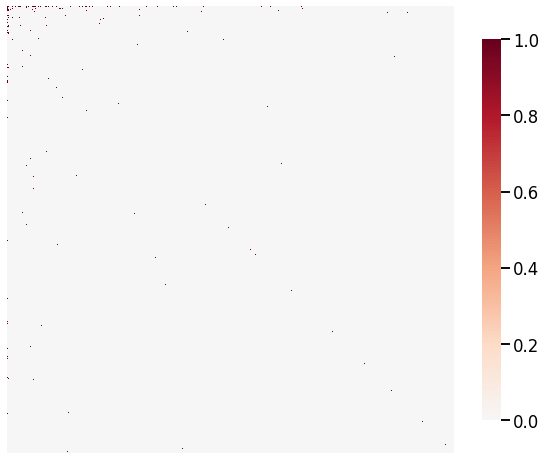

In [7]:
gp.plot.heatmap(A, sort_nodes=True)

### Node display of sample
Using a display made in NetworkX, I can hopefully see something a little more clear. for this subset

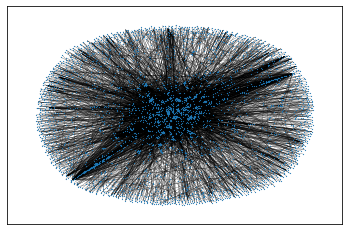

In [8]:
nx.draw_networkx(g_samp, with_labels=False, node_size=1, arrows=False, width=0.2, linewidths=0.2)

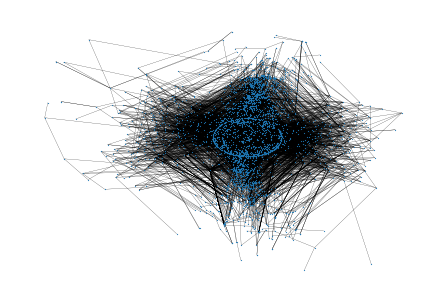

In [9]:
nx.draw_kamada_kawai(g_samp, with_labels=False, node_size=1, arrows=False, width=0.2, linewidths=0.2)

### Node display of larger graph
Using the code designed by you, I can attempt to make a visualization with the whole graph. There's still an error with the embedding process though. Maybe I'll be able to plot this better in the future

In [ ]:
n_components = 16
g_csr = g_sparse.tocsr()
ase = gp.embed.AdjacencySpectralEmbed(n_components=n_components, check_lcc=False)
ase_embedding = ase.fit_transform(g_csr)

umapper = UMAP(n_neighbors=15, metric="cosine", min_dist=0.8)
umap_embedding = umapper.fit_transform(*ase_embedding)

gp.plot.networkplot(
    g_csr,
    x=umap_embedding[:, 0],
    y=umap_embedding[:, 1],
    edge_linewidth=0.2,
    edge_alpha=0.4,
    node_kws=dict(
        s=50,  # s will change the size of nodes)
    ),
)

## Centrality

### Idea
Using the centrality methods we learned in class, this may be an effective way of "guessing" which subreddits are the most popular, which I will use as the number of subscribers. These metrics were found at https://frontpagemetrics.com/list-all-subreddits, which is an independent site compiling recent reddit metrics. There may be one centrality measure that would be much more effective than the rest at figuring out which subreddits are the most popular. Additionally, we can record the "broadness" and "intensity", in loose terms, additionally by counting the occurences of each connection, recorded as an edge attribute. 


In [10]:
subreddit_list = pd.read_csv(r'C:\Users\austi\Downloads\subreddit_list.csv', index_col=0)
subreddit_list.columns = ['subreddit', 'subscribers']
subreddit_list.head()

,subreddit,subscribers
Rank,,
1,/r/announcements,"132,658,727"
2,/r/funny,"38,650,585"
3,/r/AskReddit,"34,624,586"
4,/r/gaming,"31,472,513"
5,/r/aww,"30,044,448"


### Methodology
The first step would be to better index the dataset above. Because this is a recent dataset (compiled 2021) while the considered graph contains only data from 2014 to 2017, there will be many new subreddits of different possibility. To reduce this possibility, we will first filter out the new ones and index the top 100 subreddits by subscribers. Additionally, there are some string operations necessary to find matches.

In [11]:
subreddit_list['subreddit'] = subreddit_list['subreddit'].apply(lambda x: x[3:].lower())
node_series = pd.Series(nodelist, name='subreddit')
subreddit_list = subreddit_list.merge(node_series, how='inner')[:100]
subreddit_list.head()

,subreddit,subscribers
0,announcements,"132,658,727"
1,funny,"38,650,585"
2,askreddit,"34,624,586"
3,gaming,"31,472,513"
4,aww,"30,044,448"


We also need to define a function as a "loss" to figure out how wrong the centrality measures were wrong. This is essentially L1 loss with distance by index, since these arrays are expected to be sorted by centrality, with most central leading. The second function is used to simplify some code later.

In [12]:
def loss(target: pd.DataFrame, actual: pd.DataFrame) -> np.int64:
    sum = 0

    for index, row in target.iterrows():
        sum += abs(index - actual[actual['subreddit'] == row['subreddit']].index[0])

    return sum

def map_to_nodes(node_map: nx.DiGraph) -> np.array:
    node_map.setdefault(0)
    return np.array(np.vectorize(lambda x: node_map.setdefault(x,0))(nodelist))

### Execution
Here we will use the L1 loss above to output the average L1 loss for a node, to see which was most effective, using measures of centrality. We will also do this considering the graph as weighted and unweighted. We will not consider betweenness centrality, since it took too long to run. These statistics will be stored in a dataframe as the average L1 loss.

In [89]:
results = pd.DataFrame(columns=['type', 'weight', 'loss'])

#### Unweighted Degree

In [90]:
degrees = map_to_nodes(dict(g.degree()))
degree_df = pd.DataFrame({'subreddit': nodelist, 'centrality': degrees})
degree_df = degree_df.sort_values(by='centrality', ascending=False).set_index(np.arange(len(degree_df)))
degree_loss = loss(subreddit_list, degree_df)
results = results.append({'type': 'degree', 'weight': 'Unweighted', 'loss': degree_loss / len(subreddit_list)}, ignore_index=True)

#### Unweighted Eigenvector centrality

In [91]:
eig_df = pd.DataFrame({'subreddit': nodelist, 'centrality': map_to_nodes(dict(nx.eigenvector_centrality(g)))})
eig_df = eig_df.sort_values(by='centrality', ascending=False).set_index(np.arange(len(eig_df)))
eig_loss = loss(subreddit_list, eig_df)
results = results.append({'type': 'eigenvector', 'weight': 'Unweighted', 'loss': eig_loss / len(subreddit_list)}, ignore_index=True)

#### Unweighted PageRank

In [92]:
pr_results = np.vectorize(nx.pagerank(g, max_iter=1000).get)(nodelist)
pr_df = pd.DataFrame({'subreddit': nodelist, 'centrality': pr_results})
pr_df = pr_df.sort_values(by='centrality', ascending=False).set_index(np.arange(len(pr_df)))
pr_loss = loss(subreddit_list, pr_df)
results = results.append({'type': 'PageRank', 'weight': 'Unweighted', 'loss': pr_loss / len(subreddit_list)}, ignore_index=True)

#### Weighted Degree

In [93]:
wdegrees = np.asarray(g_sparse.sum(axis=0)).flatten() + np.asarray(g_sparse.sum(axis=1)).flatten()
wdegree_df = pd.DataFrame({'subreddit': nodelist, 'centrality': wdegrees.squeeze()})
wdegree_df = wdegree_df.sort_values(by='centrality', ascending=False).set_index(np.arange(len(wdegree_df)))
wdegree_loss = loss(subreddit_list, wdegree_df)
results = results.append({'type': 'degree', 'weight': 'Weighted', 'loss': wdegree_loss / len(subreddit_list)}, ignore_index=True)

#### Weighted Eigenvector

In [94]:
weig_df = pd.DataFrame({'subreddit': nodelist, 'centrality': map_to_nodes(dict(nx.eigenvector_centrality(g, weight='size')))})
weig_df = weig_df.sort_values(by='centrality', ascending=False).set_index(np.arange(len(weig_df)))
weig_loss = loss(subreddit_list, weig_df)
results = results.append({'type': 'eigenvector', 'weight': 'Weighted', 'loss': weig_loss / len(subreddit_list)}, ignore_index=True)

#### Weighted PageRank

In [95]:
wpr_results = np.vectorize(nx.pagerank(g, max_iter=1000, weight='size').get)(nodelist)
wpr_df = pd.DataFrame({'subreddit': nodelist, 'centrality': wpr_results})
wpr_df = wpr_df.sort_values(by='centrality', ascending=False).set_index(np.arange(len(wpr_df)))
wpr_loss = loss(subreddit_list, wpr_df)
results = results.append({'type': 'PageRank', 'weight': 'Weighted', 'loss': wpr_loss / len(subreddit_list)}, ignore_index=True)

## Conclusions

In [96]:
results.rename(mapper={'weight' : 'Average Loss'}, axis=1).pivot(index='type', columns='Average Loss', values='loss')

Average Loss,Unweighted,Weighted
type,,
PageRank,295.26,389.33
degree,292.28,404.15
eigenvector,226.98,310.39


We can see from our average L1 loss figures are above, clearly showing which settings allow for the best prediction of popular subreddits, measured by subscribers. The eigenvector centrality measure was best overall, with degree and PageRank working with approximately the same accuracy. Additionally, across the board, the weighted measurements greatly underperformed the unweighted representation. This conclusion can lead us to the fact that a better indicator of popularity is the amount of subreddits that relate to the content. not the number of times this subreddit is referenced in total. Likely, this was due to some relatively unpopular subreddits refverencing each other in isolated communities.

Finally, we can use this to see which subreddits were likely to be most popular 5-8 years ago.

In [105]:
eig_df.head(25)

,subreddit,centrality
0,iama,0.245731
1,askreddit,0.237335
2,pics,0.201227
3,funny,0.196630
4,videos,0.192949
5,todayilearned,0.176295
6,worldnews,0.140717
7,gaming,0.138902
8,news,0.137688
9,gifs,0.126054
